# Problem Statement


BoomBikes, a major US bike-sharing provider, is facing revenue challenges due to the Covid-19 pandemic. To bounce back, they've hired a consulting firm to analyze the factors influencing the demand for shared bikes in the American market post-lockdown. The goal is to identify significant variables and gauge their impact on bike demand, allowing BoomBikes to tailor their services effectively. This strategic move aims to position BoomBikes as a market leader, anticipating and meeting post-pandemic consumer demands for shared bike services.

The company wants to know:

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

### Import Libraries 

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv

import sklearn
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor



/Users/sudipkandel/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Read the data

data = pd.read_csv('day.csv')

In [4]:
data.shape

(730, 16)

In [5]:
data['holiday'].unique()

array([0, 1])

In [6]:
data.isna().any().sum() # No nulls

0

## Perform some basic Data Checks 

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB
None


In [8]:
data[[ 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt']].describe()

,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [9]:
import sweetviz as sv
dq_report = sv.analyze(data)
dq_report.show_html('DQ_data.html')

Feature: instant                             |▌         | [  6%]   00:00 -> (00:00 left)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report DQ_data.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### From the above DQ Report we can conclude that:
-  There are 730 records and 16 columns - We dropped the index column
-  We also observe the data has no nulls as ML model doesnt accept nulls
-  There is also no unusual data issues or duplicate columns etc observed.

So, lets go ahead

# Clean the Data for Feature Selection

In [10]:
if (data['casual'] + data['registered'] == data['cnt']).all():
    print('Sum of Casual and Registed is total Count.')
else:
    print('Sum of Casual and Registed is not equal to total Count.')

# From this we can see that causal and registered sum are equal to count so we can drop 
# 'casual' and 'registered'

Sum of Casual and Registed is total Count.


In [11]:
# drop the columns which are not helpful in analysis
# Drop date column too - year and month has the required info from the time series
data = data.drop(columns=['instant',
                          'casual',
                          'registered',
                          'dteday']) 

In [12]:
# Rename the columns

data = data.rename(columns={
                        'yr':'year',
                        'mnth':'month'})

In [13]:
data

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,2114
726,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,3095
727,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,1341
728,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,1796


# EDA and Outlier Check

/Users/sudipkandel/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sudipkandel/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sudipkandel/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sudipkandel/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

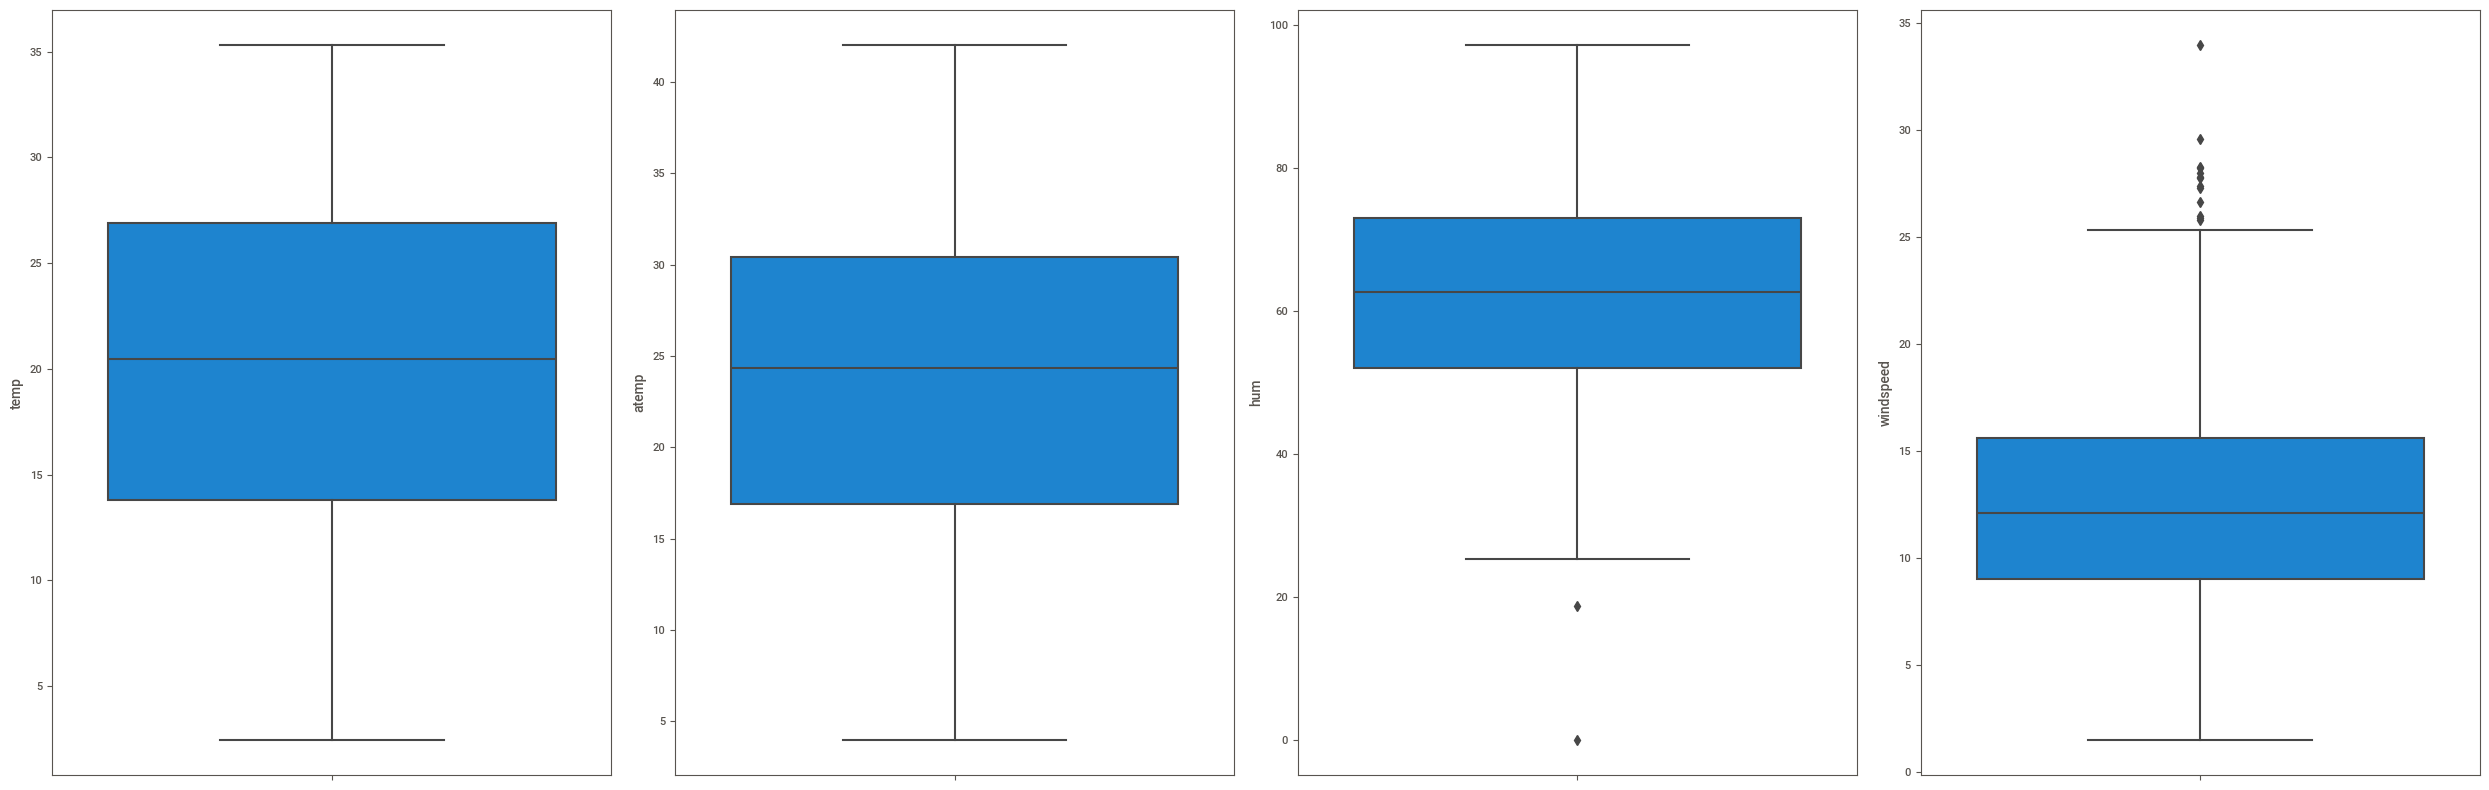

In [14]:
# Step 1 - check for any extreme case of outlier in the data 
# To check that we can use box plot
numerical_var = ['temp', 'atemp', 'hum', 'windspeed']
fig, axes = plt.subplots(1, len(numerical_var), figsize=(25, 8))

for i, col in enumerate(numerical_var):
    sns.boxplot(y=col, data=data, ax=axes[i])

plt.tight_layout()
plt.show()

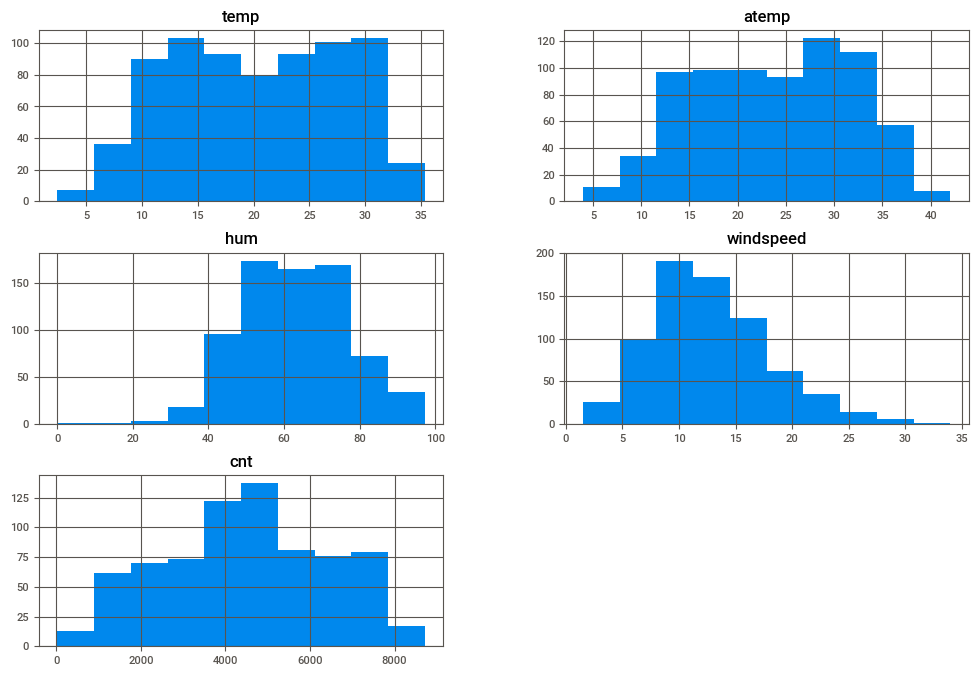

In [15]:
# Checking the data distribution

data[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].hist(figsize=(12, 8))
plt.show()

In [16]:
# Observe the correlation matrix
correlation_matrix = data.corr()
correlation_matrix

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
season,1.000000e+00,-3.279074e-16,8.310321e-01,-0.010868,-0.003081,0.013762,0.021306,0.333361,0.342014,0.208220,-0.229607,0.404584
year,-3.279074e-16,1.000000e+00,-5.162656e-16,0.008195,-0.005466,-0.002945,-0.050322,0.048789,0.047215,-0.112547,-0.011624,0.569728
month,8.310321e-01,-5.162656e-16,1.000000e+00,0.018905,0.009523,-0.004688,0.045613,0.219083,0.226430,0.224937,-0.208013,0.278191
holiday,-1.086804e-02,8.195345e-03,1.890483e-02,1.000000,-0.101962,-0.252948,-0.034395,-0.028764,-0.032703,-0.015662,0.006257,-0.068764
weekday,-3.081198e-03,-5.466369e-03,9.522969e-03,-0.101962,1.000000,0.035800,0.031112,-0.000168,-0.007539,-0.052290,0.014283,0.067534
workingday,1.376178e-02,-2.945396e-03,-4.687953e-03,-0.252948,0.035800,1.000000,0.060236,0.053470,0.052940,0.023202,-0.018666,0.062542
weathersit,2.130636e-02,-5.032247e-02,4.561335e-02,-0.034395,0.031112,0.060236,1.000000,-0.119503,-0.120559,0.590277,0.039769,-0.295929
temp,3.333607e-01,4.878919e-02,2.190833e-01,-0.028764,-0.000168,0.053470,-0.119503,1.000000,0.991696,0.128565,-0.158186,0.627044
atemp,3.420139e-01,4.721519e-02,2.264302e-01,-0.032703,-0.007539,0.052940,-0.120559,0.991696,1.000000,0.141512,-0.183876,0.630685
hum,2.082196e-01,-1.125471e-01,2.249368e-01,-0.015662,-0.052290,0.023202,0.590277,0.128565,0.141512,1.000000,-0.248506,-0.098543


In [17]:
# Now lets go ahead with the Categorical fix and encodings from the data dictionary

# Convert 'season' column
season_mapping = {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}
data['season'] = data['season'].replace(season_mapping)

# Convert 'year' column
year_mapping = {0: 2018, 1: 2019}
data['year'] = data['year'].replace(year_mapping)

# Convert 'month' column
month_mapping = {1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun',
                 7: 'jul', 8: 'aug', 9: 'sept', 10: 'oct', 11: 'nov', 12: 'dec'}
data['month'] = data['month'].replace(month_mapping)

# Convert 'weekday' column
weekday_mapping = {0: 'sun', 1: 'mon', 2: 'tue', 3: 'wed', 4: 'thu', 5: 'fri', 6: 'sat'}
data['weekday'] = data['weekday'].replace(weekday_mapping)

weathersit_mapping_short = {
    1: 'Clear',
    2: 'Mist_Cloudy',
    3: 'LightRain_Snow',
    4: 'HeavyRain_Snow'
}
data['weathersit'] = data['weathersit'].replace(weathersit_mapping_short)


In [18]:
data

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,jan,0,sat,0,Mist_Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,jan,0,sun,0,Mist_Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,jan,0,mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,jan,0,tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,jan,0,wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
725,spring,2019,dec,0,thu,1,Mist_Cloudy,10.420847,11.33210,65.2917,23.458911,2114
726,spring,2019,dec,0,fri,1,Mist_Cloudy,10.386653,12.75230,59.0000,10.416557,3095
727,spring,2019,dec,0,sat,0,Mist_Cloudy,10.386653,12.12000,75.2917,8.333661,1341
728,spring,2019,dec,0,sun,0,Clear,10.489153,11.58500,48.3333,23.500518,1796


In [19]:
# If you observe the correlation matrix we can see that atemp is correlated to temp

# lets visualize in sns.heatmap for numerical variables alone

In [20]:
numerical_plot = numerical_var + ['cnt'] # cnt is the target variable

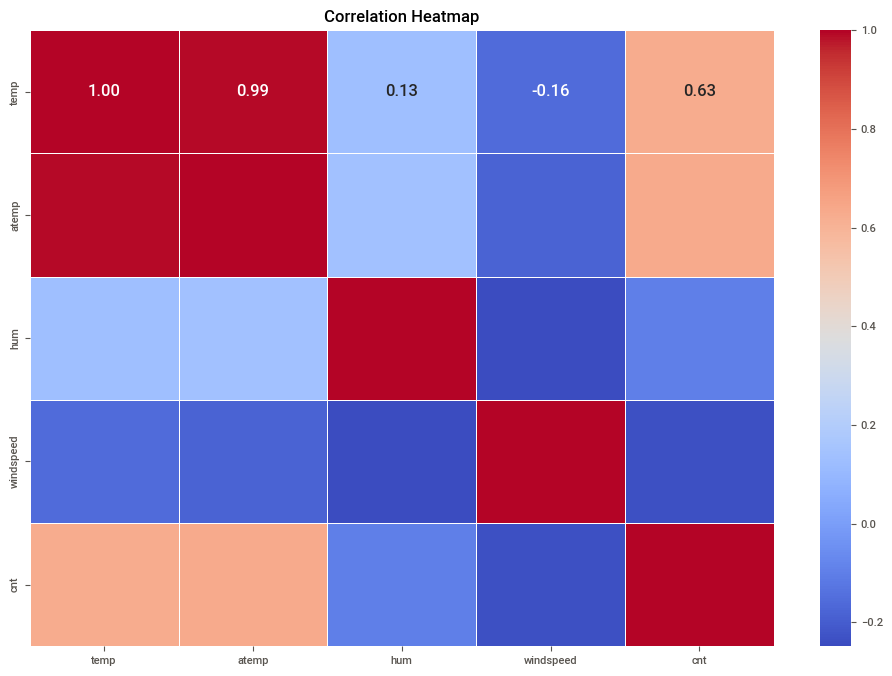

In [21]:
plt.figure(figsize=(12, 8))

# Create heatmap using Seaborn
sns.heatmap(data[numerical_plot].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5,annot_kws={"size": 12})

# Show the plot
plt.title('Correlation Heatmap')
plt.show()

In [22]:
# We can observe that temp and atemp are highly corelated, lets also plot a pairplot

/Users/sudipkandel/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sudipkandel/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sudipkandel/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sudipkandel/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

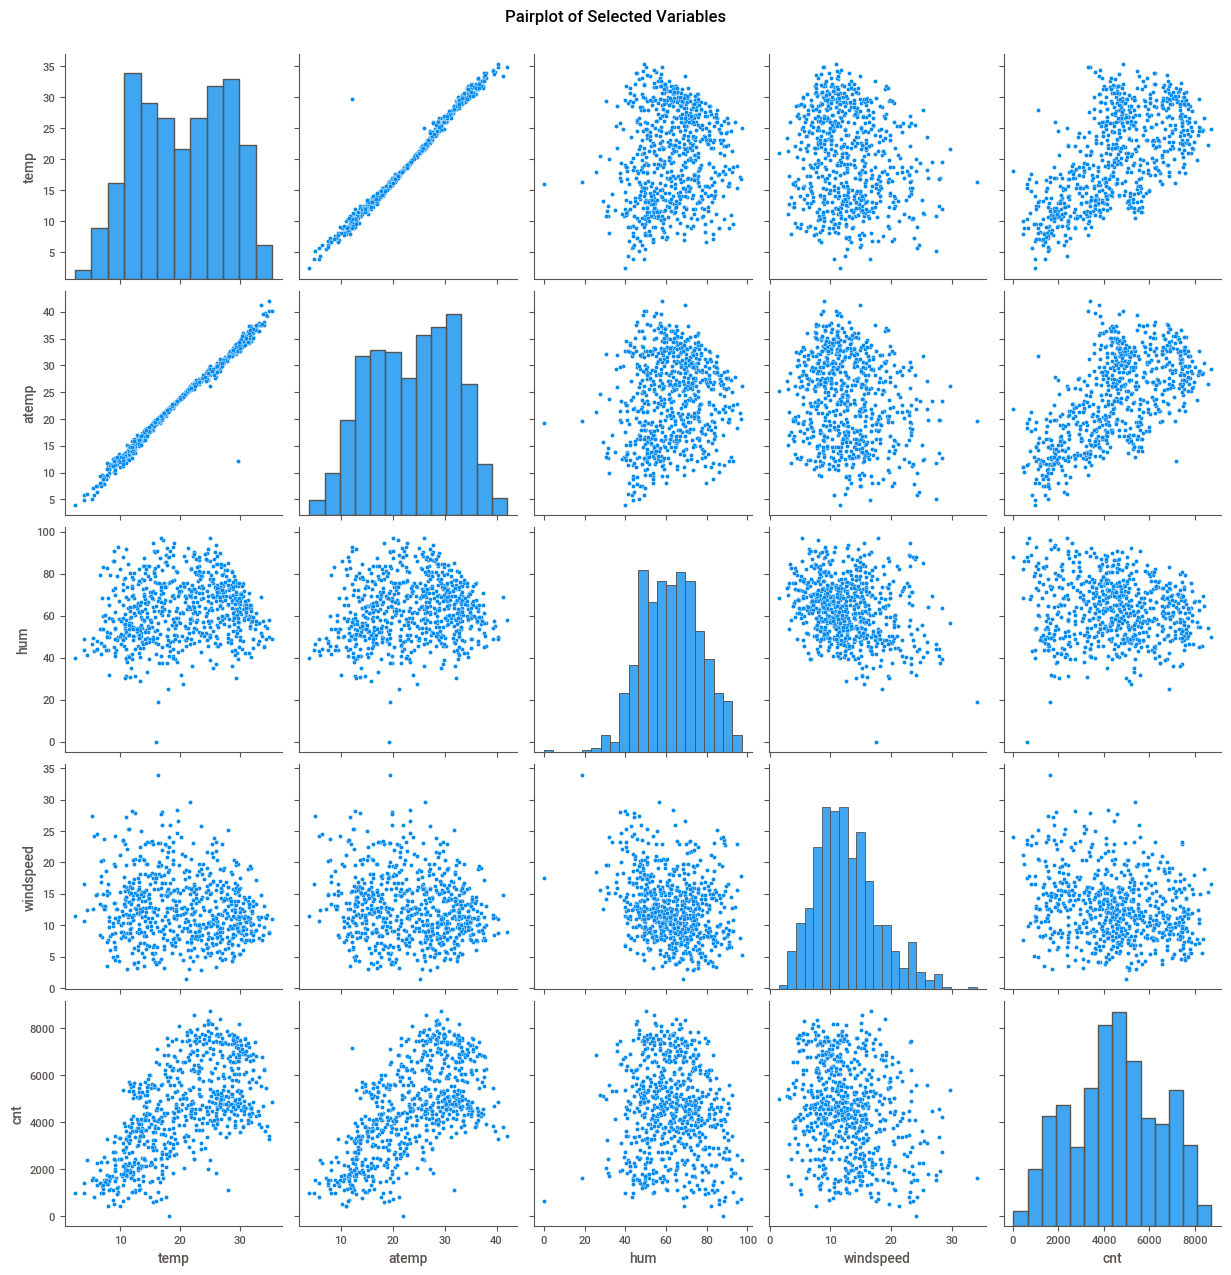

In [23]:
# Pairplot
sns.pairplot(data[numerical_plot])

# Show the plot
plt.suptitle('Pairplot of Selected Variables', y=1.02)
plt.show()

From the Above Observation -
- atemp and temp are correlated
- Also, they are having linear relationship with each other

In [24]:
# Now lets look at categorical variables with target variable

/Users/sudipkandel/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sudipkandel/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sudipkandel/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sudipkandel/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

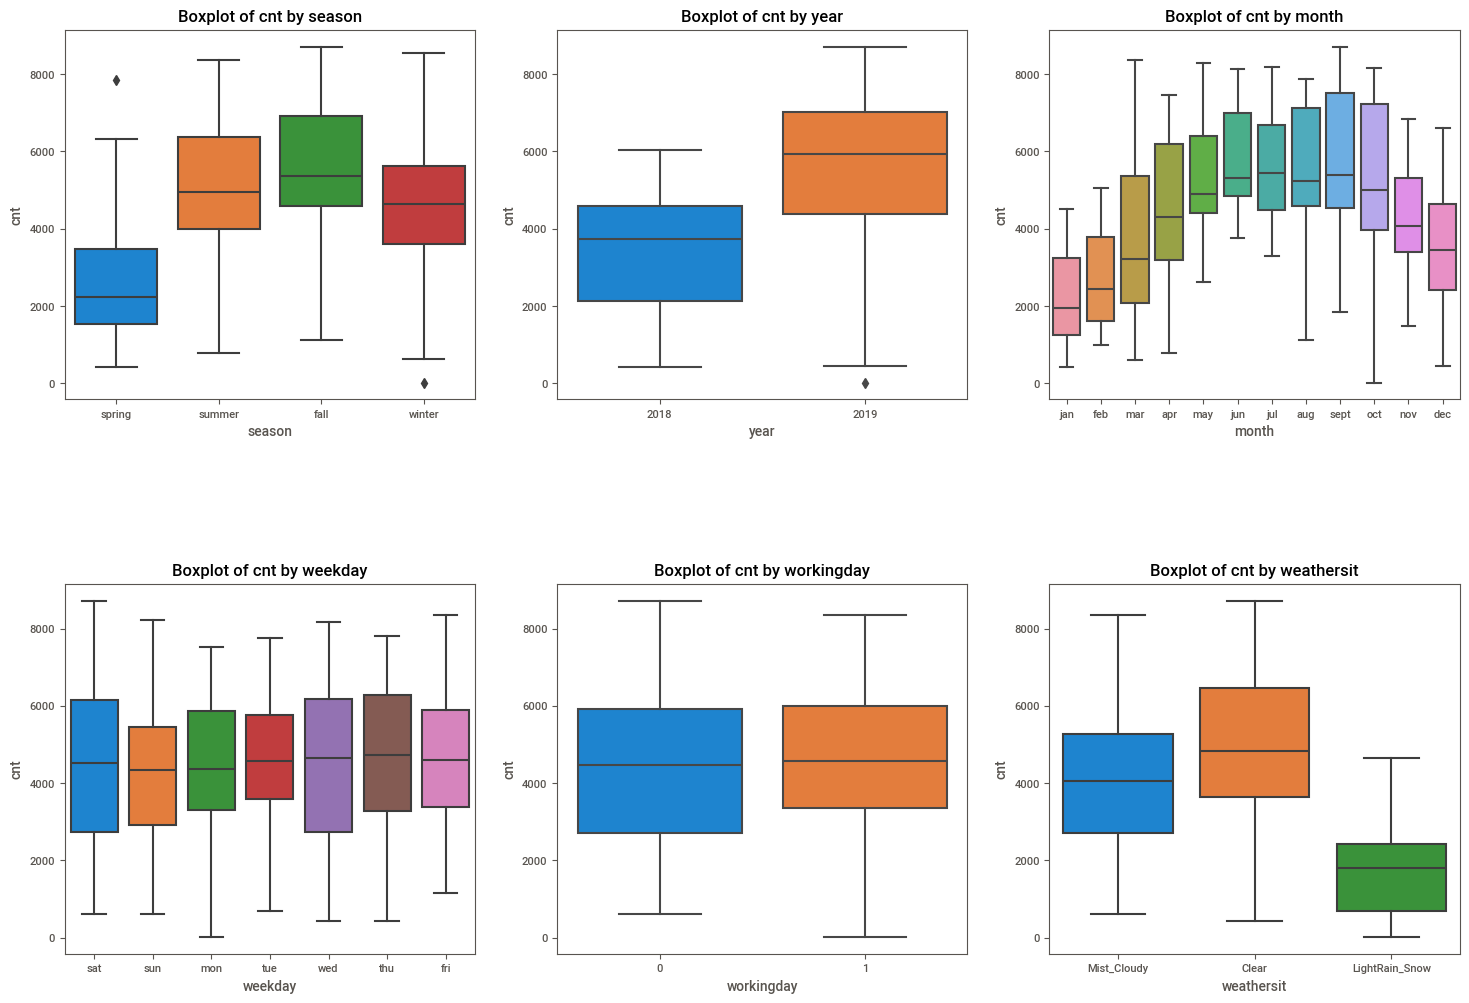

In [25]:
# Categorical variables and the target variable
categorical_variables = ['season', 'year', 'month', 'weekday', 'workingday', 'weathersit']
target_variable = 'cnt'

# Set up the matplotlib figure
plt.figure(figsize=(18, 12))
plt.subplots_adjust(hspace=0.5)

# Create boxplots for each categorical variable
for i, cat_var in enumerate(categorical_variables, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=cat_var, y=target_variable, data=data)
    plt.title(f'Boxplot of {target_variable} by {cat_var}')

# Show the plot
plt.show()

# Linear Regression Model Development

> First we need to treat the categorical variable with dummies


In [26]:
data

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,jan,0,sat,0,Mist_Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,jan,0,sun,0,Mist_Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,jan,0,mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,jan,0,tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,jan,0,wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
725,spring,2019,dec,0,thu,1,Mist_Cloudy,10.420847,11.33210,65.2917,23.458911,2114
726,spring,2019,dec,0,fri,1,Mist_Cloudy,10.386653,12.75230,59.0000,10.416557,3095
727,spring,2019,dec,0,sat,0,Mist_Cloudy,10.386653,12.12000,75.2917,8.333661,1341
728,spring,2019,dec,0,sun,0,Clear,10.489153,11.58500,48.3333,23.500518,1796


In [27]:
data = pd.get_dummies(data,columns = ['season','month','weekday','weathersit'], drop_first=True)

# drop first because we dont want extra column for representation

In [28]:
bool_cols = data.select_dtypes(include='bool').columns
data[bool_cols] = data[bool_cols].astype(int)

In [29]:
data.shape

(730, 30)

# Now lets train the model 

In [30]:
from sklearn.model_selection import train_test_split
np.random.seed(0)

# Separate the target variable 'cnt' and the independent variables
y = data.pop('cnt')  # Target variable

# Set X to include all other features (independent variables)
X = data

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=67)


In [31]:
X_train.shape

(511, 29)

In [32]:
# Use scaling method to Standarize the data 

# Identify continuous variables for scaling
continuous_vars = ['temp', 'atemp', 'hum', 'windspeed']

# Use Min-Max Scaler to scale the continuous variables
scaler = MinMaxScaler()

# Fit and transform the training set for the identified continuous variables
X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])



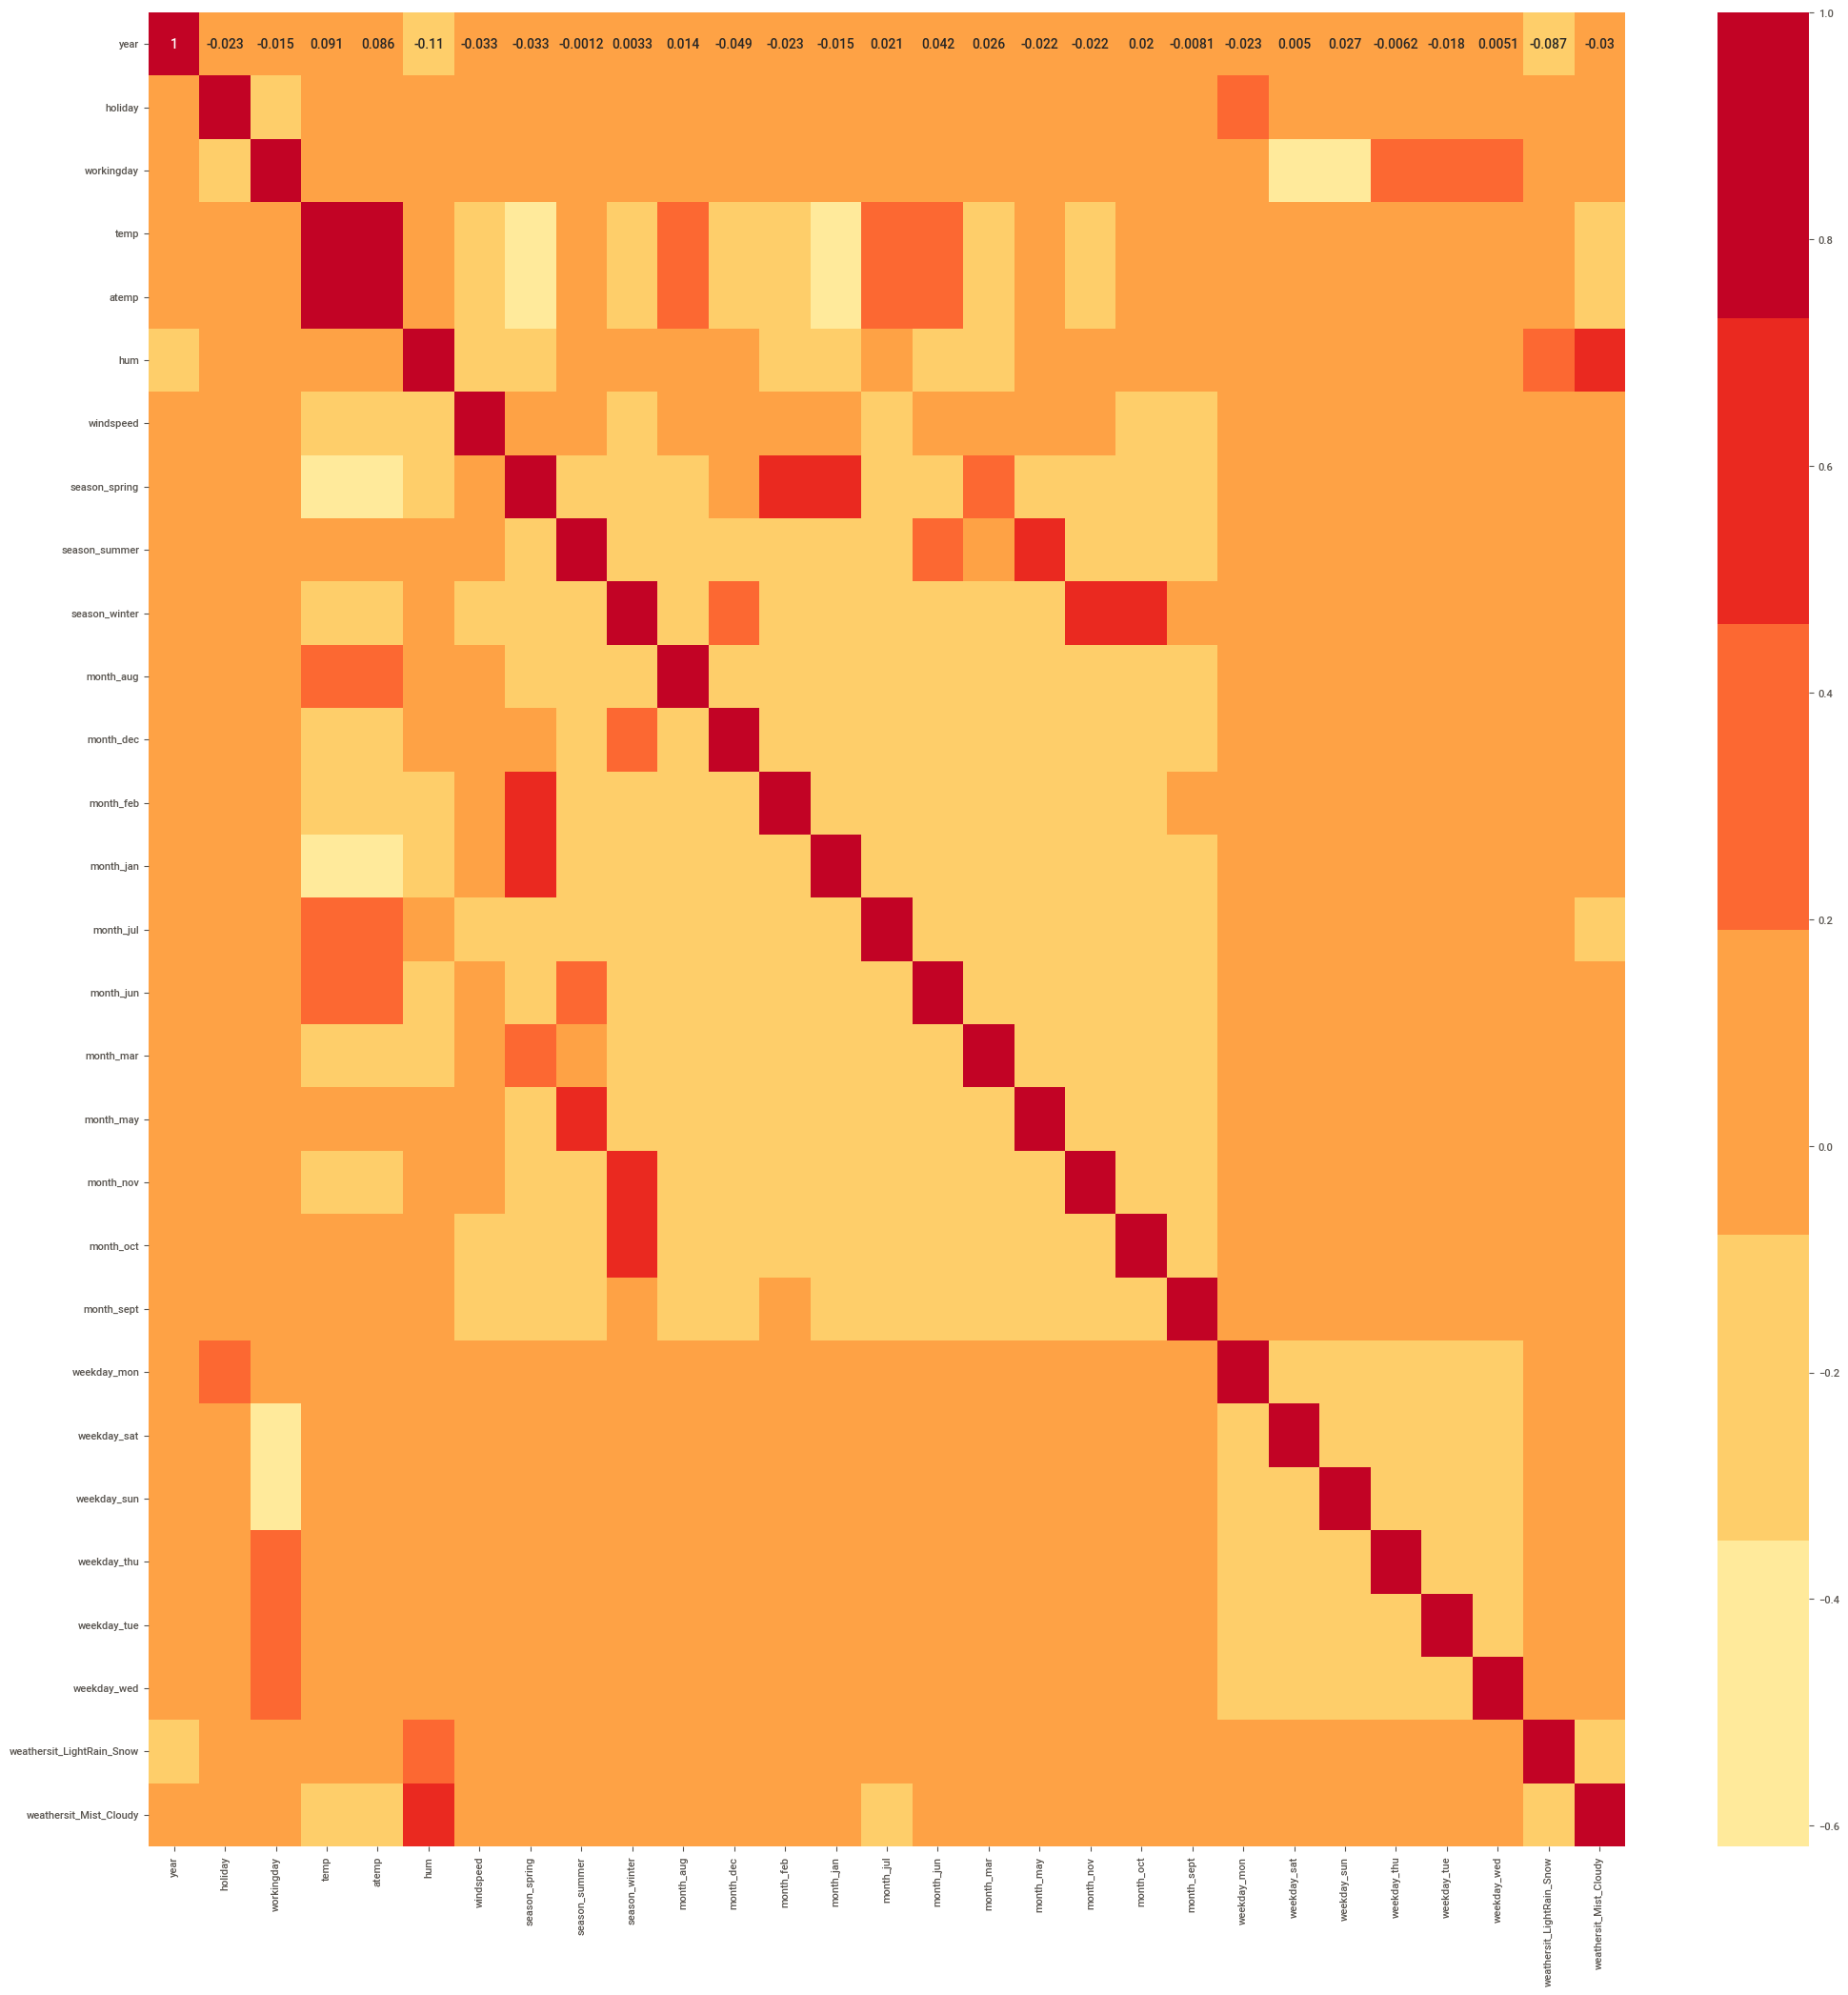

In [33]:
plt.figure(figsize=(25, 25))

# Set the colormap to go from green to amber
cmap = sns.color_palette("YlOrRd")

sns.heatmap(X_train.corr(), annot=True, cmap=cmap)
plt.show()


#### From the Above Correlation Matrix - we can observe :
1. temp and atemp are highly correlated
2. Nov and Oct month are correlated with Season Winter, May month to Summer, Jan/Feb to Spring

###### From this Matrix we will try to observe and build the model 

#### Model Building

In [34]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [35]:
rfe = RFE(lr, n_features_to_select = 15)
rfe.fit(X_train,y_train)


RFE(estimator=LinearRegression(), n_features_to_select=15)

In [36]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))


[('year', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 11),
 ('season_winter', True, 1),
 ('month_aug', False, 6),
 ('month_dec', False, 3),
 ('month_feb', False, 4),
 ('month_jan', False, 2),
 ('month_jul', True, 1),
 ('month_jun', False, 7),
 ('month_mar', False, 12),
 ('month_may', False, 13),
 ('month_nov', True, 1),
 ('month_oct', False, 15),
 ('month_sept', True, 1),
 ('weekday_mon', False, 8),
 ('weekday_sat', True, 1),
 ('weekday_sun', True, 1),
 ('weekday_thu', False, 14),
 ('weekday_tue', False, 10),
 ('weekday_wed', False, 9),
 ('weathersit_LightRain_Snow', True, 1),
 ('weathersit_Mist_Cloudy', False, 5)]

In [37]:
import statsmodels.api as sm

# Function to build and summarize a linear regression model using statsmodels API
def sm_model(cols):
    """
    Build and summarize a linear regression model using statsmodels.

    Parameters:
    - cols: List of column names to use as independent variables.

    Returns:
    - lm: The fitted statsmodels OLS regression model.
    """

    # Add a constant term to the independent variables
    X_train_sm = sm.add_constant(X_train[cols])

    # Fit the OLS regression model
    lm = sm.OLS(y_train, X_train_sm).fit()

    # Display the summary of the regression model
    print(lm.summary())

    return lm


In [38]:

# Function to calculate VIFs and print them - Takes the columns for which VIF to be calculated as a parameter
def get_vif(cols):
    """
    Calculate and print Variance Inflation Factors (VIFs) for the given columns.

    Parameters:
    - cols: List of column names for which VIFs should be calculated.
    """

    # Extract the relevant columns from the training set
    # Create a DataFrame to store feature names and their corresponding VIFs
    vif = pd.DataFrame()
    df = X_train[cols]
    vif['Features'] = df[cols].columns
    vif['VIF'] = [variance_inflation_factor(df[cols].values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by='VIF', ascending=False)
    return vif


In [39]:

rfe_results = X_train.columns[rfe.support_]
print("Columns selected by RFE:")
print(rfe_results)

Columns selected by RFE:
Index(['year', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'season_spring', 'season_winter', 'month_jul', 'month_nov',
       'month_sept', 'weekday_sat', 'weekday_sun',
       'weathersit_LightRain_Snow'],
      dtype='object')


In [40]:

print("Columns not selected by RFE:")
print(X_train.columns[~rfe.support_])

Columns not selected by RFE:
Index(['season_summer', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jun', 'month_mar', 'month_may', 'month_oct', 'weekday_mon',
       'weekday_thu', 'weekday_tue', 'weekday_wed', 'weathersit_Mist_Cloudy'],
      dtype='object')


In [41]:
rfe_list = rfe_results.tolist()
X_train_rfe = X_train[rfe_list]

In [42]:
rfe_results.tolist()

['year',
 'holiday',
 'workingday',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'season_spring',
 'season_winter',
 'month_jul',
 'month_nov',
 'month_sept',
 'weekday_sat',
 'weekday_sun',
 'weathersit_LightRain_Snow']

In [43]:
# get_vif(rfe_list)


In [44]:
# workingday	
# weekday_sat
# weekday_sun
# holiday
# temp
# atemp

#These KPI are having high VIF but we need to drop column one at a time. 

In [45]:
rfe_list

['year',
 'holiday',
 'workingday',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'season_spring',
 'season_winter',
 'month_jul',
 'month_nov',
 'month_sept',
 'weekday_sat',
 'weekday_sun',
 'weathersit_LightRain_Snow']

# Experimentation

In [46]:
rfe_list = ['year',
 'holiday',
 'workingday',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'season_spring',
 'season_winter',
 'month_jul',
 'month_sept',
 'weekday_sat',
 'weekday_sun',
 'weathersit_LightRain_Snow',
 'weathersit_Mist_Cloudy']

sm_model(rfe_list)
get_vif(rfe_list)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     184.3
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          3.32e-186
Time:                        23:00:28   Log-Likelihood:                -4135.2
No. Observations:                 511   AIC:                             8300.
Df Residuals:                     496   BIC:                             8364.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
2,workingday,11591434.50
12,weekday_sun,2557568.06
11,weekday_sat,2291756.25
1,holiday,531382.00
3,temp,52.47
4,atemp,50.72
7,season_spring,2.40
5,hum,2.01
8,season_winter,1.75
14,weathersit_Mist_Cloudy,1.66


In [47]:
# atemp has high p-value remove it 

rfe_list = ['year',
 'holiday',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_spring',
 'season_winter',
 'month_jul',
 'month_sept',
 'weekday_sat',
 'weekday_sun',
 'weathersit_LightRain_Snow',
 'weathersit_Mist_Cloudy']

sm_model(rfe_list)
get_vif(rfe_list)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     198.1
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          5.45e-187
Time:                        23:00:28   Log-Likelihood:                -4136.1
No. Observations:                 511   AIC:                             8300.
Df Residuals:                     497   BIC:                             8359.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
2,workingday,11582168.41
11,weekday_sun,2555521.39
10,weekday_sat,2289924.08
1,holiday,530958.94
3,temp,2.80
6,season_spring,2.40
4,hum,2.00
7,season_winter,1.74
13,weathersit_Mist_Cloudy,1.66
8,month_jul,1.33


In [48]:
# p-value looks fine but workingday vif is too huge remove it 

rfe_list = ['year',
 'holiday',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_spring',
 'season_winter',
 'month_jul',
 'month_sept',
 'weekday_sat',
 'weekday_sun',
 'weathersit_LightRain_Snow',
 'weathersit_Mist_Cloudy']

sm_model(rfe_list)
get_vif(rfe_list)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     198.1
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          5.45e-187
Time:                        23:00:28   Log-Likelihood:                -4136.1
No. Observations:                 511   AIC:                             8300.
Df Residuals:                     497   BIC:                             8359.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
2,workingday,11582168.41
11,weekday_sun,2555521.39
10,weekday_sat,2289924.08
1,holiday,530958.94
3,temp,2.80
6,season_spring,2.40
4,hum,2.00
7,season_winter,1.74
13,weathersit_Mist_Cloudy,1.66
8,month_jul,1.33


In [49]:
# p-value looks fine but workingday vif is too huge remove it 

rfe_list = ['year',
 'holiday',
 'temp',
 'hum',
 'windspeed',
 'season_spring',
 'season_winter',
 'month_jul',
 'month_sept',
 'weekday_sat',
 'weekday_sun',
 'weathersit_LightRain_Snow',
 'weathersit_Mist_Cloudy']

sm_model(rfe_list)
get_vif(rfe_list)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     198.1
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          5.45e-187
Time:                        23:00:28   Log-Likelihood:                -4136.1
No. Observations:                 511   AIC:                             8300.
Df Residuals:                     497   BIC:                             8359.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,year,61.56
3,hum,38.69
2,temp,18.43
4,windspeed,7.05
5,season_spring,3.15
12,weathersit_Mist_Cloudy,2.47
6,season_winter,2.32
7,month_jul,1.45
11,weathersit_LightRain_Snow,1.28
10,weekday_sun,1.25


In [50]:
# p-value looks fine but year vif is too huge remove it 

rfe_list = [
 'holiday',
 'temp',
 'hum',
 'windspeed',
 'season_spring',
 'season_winter',
 'month_jul',
 'month_sept',
 'weekday_sat',
 'weekday_sun',
 'weathersit_LightRain_Snow',
 'weathersit_Mist_Cloudy']

sm_model(rfe_list)
get_vif(rfe_list)



                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     56.31
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           1.05e-84
Time:                        23:00:28   Log-Likelihood:                -4382.5
No. Observations:                 511   AIC:                             8791.
Df Residuals:                     498   BIC:                             8846.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
2,hum,21.69
1,temp,13.88
3,windspeed,4.96
4,season_spring,2.47
11,weathersit_Mist_Cloudy,2.28
5,season_winter,2.03
6,month_jul,1.44
9,weekday_sun,1.24
10,weathersit_LightRain_Snow,1.21
8,weekday_sat,1.19


In [51]:
# p-value looks fine but hum vif is too huge remove it 

rfe_list = [
 'holiday',
 'temp',
 'windspeed',
 'season_spring',
 'season_winter',
 'month_jul',
 'month_sept',
 'weekday_sat',
 'weekday_sun',
 'weathersit_LightRain_Snow',
 'weathersit_Mist_Cloudy']

sm_model(rfe_list)
get_vif(rfe_list)



                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     56.09
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           5.27e-80
Time:                        23:00:28   Log-Likelihood:                -4395.9
No. Observations:                 511   AIC:                             8816.
Df Residuals:                     499   BIC:                             8867.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
2,windspeed,4.92
1,temp,4.74
3,season_spring,1.70
10,weathersit_Mist_Cloudy,1.48
5,month_jul,1.41
4,season_winter,1.38
8,weekday_sun,1.21
7,weekday_sat,1.19
6,month_sept,1.17
9,weathersit_LightRain_Snow,1.07


In [52]:
# now vif is below 5, so check for p-value one more time.weekday_sat has p-val greater than 0.05 remove it 


rfe_list = [
 'holiday',
 'temp',
 'windspeed',
 'season_spring',
 'season_winter',
 'month_jul',
 'month_sept',
 'weekday_sun',
 'weathersit_LightRain_Snow',
 'weathersit_Mist_Cloudy']

sm_model(rfe_list)
get_vif(rfe_list)



                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     61.54
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           1.21e-80
Time:                        23:00:28   Log-Likelihood:                -4396.5
No. Observations:                 511   AIC:                             8815.
Df Residuals:                     500   BIC:                             8862.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
2,windspeed,4.89
1,temp,4.70
3,season_spring,1.69
9,weathersit_Mist_Cloudy,1.48
5,month_jul,1.41
4,season_winter,1.38
7,weekday_sun,1.18
6,month_sept,1.17
8,weathersit_LightRain_Snow,1.07
0,holiday,1.05


In [53]:
# now vif is below 5, so check for p-value one more time.month_sept has p-val greater than 0.05 remove it 


final_cols = [
 'temp',
 'windspeed',
 'season_spring',
 'season_winter',
 'month_jul',
 'weekday_sun',
 'weathersit_LightRain_Snow',
 'weathersit_Mist_Cloudy']

sm_model(rfe_list)
get_vif(rfe_list)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     61.54
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           1.21e-80
Time:                        23:00:28   Log-Likelihood:                -4396.5
No. Observations:                 511   AIC:                             8815.
Df Residuals:                     500   BIC:                             8862.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
2,windspeed,4.89
1,temp,4.70
3,season_spring,1.69
9,weathersit_Mist_Cloudy,1.48
5,month_jul,1.41
4,season_winter,1.38
7,weekday_sun,1.18
6,month_sept,1.17
8,weathersit_LightRain_Snow,1.07
0,holiday,1.05


In [54]:
# F - statistics is nearly zero and p-value is below 0.05. Also, VIF is below 5. So, lets go ahead with this model

In [55]:
#Build a model with all columns to select features automatically
def build_model_sk(X,y):
    lr1 = LinearRegression()
    lr1.fit(X,y)
    return lr1

In [56]:
#Let us build the finalmodel using sklearn
#Build a model with above columns
lr = build_model_sk(X_train[final_cols],y_train)
print(lr.intercept_,lr.coef_)

2852.1626439792344 [ 4787.23561821 -1354.62061783  -815.7108542    604.96962801
  -839.38957816  -319.47991679 -3111.45078368  -703.51204662]


In [57]:
y_train_pred = lr.predict(X_train[final_cols])


In [58]:
#Plot a histogram of the error terms
def plot_res_dist(act, pred):
    sns.distplot(act-pred)
    plt.title('Error Terms')
    plt.xlabel('Errors')

/var/folders/x0/69vklmkd76s0_014lrw862j00000gn/T/ipykernel_19074/3357394689.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(act-pred)
/Users/sudipkandel/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sudipkandel/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

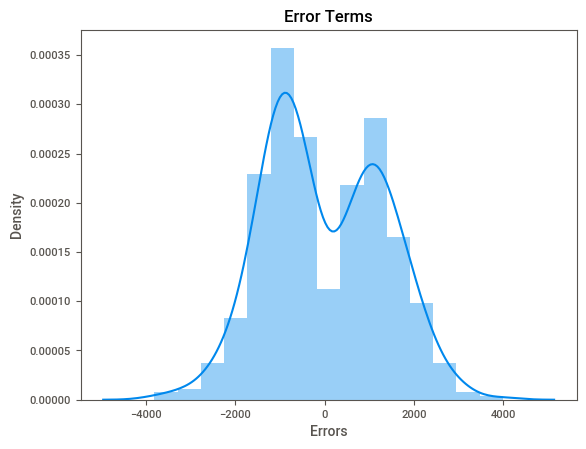

In [59]:
plot_res_dist(y_train, y_train_pred)


In [60]:
# The error terms doesnt looks so good but we can experiment and observe the model performance

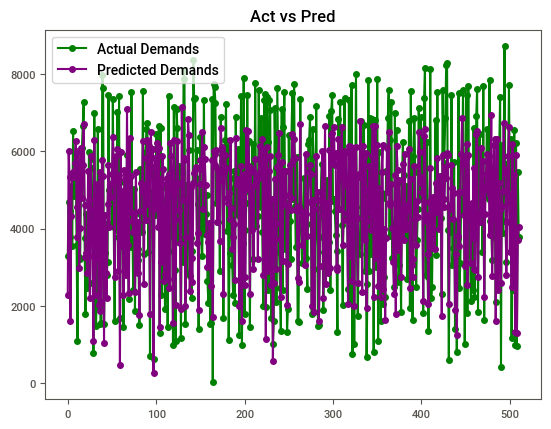

In [61]:
# Visualizing Actual vs Predicted Demands
index_range = range(len(X_train))
plt.plot(index_range, y_train, color="green", label="Actual Demands", marker='o', linestyle='-', markersize=4)
plt.plot(index_range, y_train_pred, color="purple", label="Predicted Demands", marker='o', linestyle='-', markersize=4)
plt.title('Act vs Pred')
plt.legend()
plt.show()


In [62]:
#Print R-squared Value
r2_score(y_train,y_train_pred)

0.5460021792074069

In [63]:
# Scaling variables in X_test
num_vars = ['temp', 'atemp', 'hum', 'windspeed']

# Transforming test data without fitting
X_test[num_vars] = scaler.transform(X_test[num_vars])


In [64]:

# Predicting test data values
y_test_pred = lr.predict(X_test[final_cols])


In [65]:
r2_score(y_test,y_test_pred) # Calculating the R2 Score 


0.5323536347048168

In [66]:
y_pred=y_test_pred
r2_score(y_test, y_pred)

0.5323536347048168

Text(0, 0.5, 'y - pred')

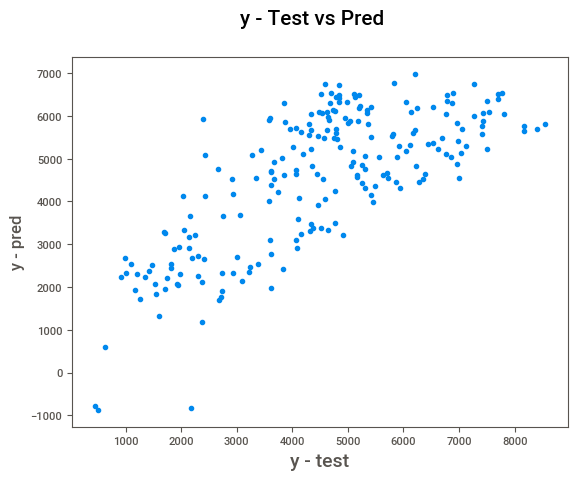

In [67]:
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y - Test vs Pred', fontsize = 15)             
plt.xlabel('y - test', fontsize = 14)                          
plt.ylabel('y - pred', fontsize = 12) 

In [68]:
# Although the model perfomance was average we could see some linear relationship between test and pred.

# we need to do recursive Trial error by observing the P-value, VIF for multicollinearity to get the maximum model improvement

In [ ]:
# Further improvement can be done by adding Derived metrics.